**Import Libraries**

In [1]:
import os
import random
import shutil
import time
import collections
import pandas as pd
import copy

import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models


from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm, trange


**Random Seed Initialization**

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed (SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

**Mount to Google drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


**Unpack the dataset**

In [4]:
#shutil.unpack_archive("/content/drive/MyDrive/Kwok_Bo_22454220_Code/train-image.zip", "/content/drive/MyDrive/Kwok_Bo_22454220_Code/")

**Data Preparation**

In [5]:
csv_file = '/content/drive/My Drive/Kwok_Bo_22454220_Code/train-metadata-preparation.csv'
original_images_folder = '/content/drive/My Drive/Kwok_Bo_22454220_Code/train-image/image'
extracted_images_folder = '/content/drive/My Drive/Kwok_Bo_22454220_Code/image'


data = pd.read_csv(csv_file, dtype={51: str, 52: str})

for index, row in data.iterrows():

  image_name = str(row['isic_id']) + ".jpg"
  image_class = row['target']

  if image_class == 0 :
      target_folder = extracted_images_folder
  elif image_class == 1 :
      target_folder = extracted_images_folder
  else:
      continue

  source_path = os.path.join(original_images_folder, image_name)
  destination_path = os.path.join(extracted_images_folder, image_name)

  if os.path.exists(source_path):
    shutil.copy(source_path, destination_path)
  else:
    print(f"Image {image_name} not found in {original_images_folder}")



In [6]:
from sklearn.model_selection import train_test_split

train_data_csv_file = '/content/drive/My Drive/Kwok_Bo_22454220_Code/train_data.csv'
valid_data_csv_file = '/content/drive/My Drive/Kwok_Bo_22454220_Code/valid_data.csv'
test_data_csv_file = '/content/drive/My Drive/Kwok_Bo_22454220_Code/test_data.csv'
extracted_images_folder = '/content/drive/My Drive/Kwok_Bo_22454220_Code/image'
output_folder = '/content/drive/My Drive/Kwok_Bo_22454220_Code'

train_image_folder = os.path.join(output_folder, 'train_image')
valid_image_folder = os.path.join(output_folder, 'valid_image')
test_image_folder = os.path.join(output_folder, 'test_image')

os.makedirs(os.path.join(train_image_folder, 'benign'), exist_ok=True)
os.makedirs(os.path.join(train_image_folder, 'malignant'), exist_ok=True)
os.makedirs(os.path.join(valid_image_folder, 'benign'), exist_ok=True)
os.makedirs(os.path.join(valid_image_folder, 'malignant'), exist_ok=True)
os.makedirs(os.path.join(test_image_folder, 'benign'), exist_ok=True)
os.makedirs(os.path.join(test_image_folder, 'malignant'), exist_ok=True)
#os.makedirs(test_image_folder, exist_ok=True)

train_csv_path = os.path.join(output_folder, "train_data.csv")
valid_csv_path = os.path.join(output_folder, "valid_data.csv")
test_csv_path = os.path.join(output_folder, "test_data.csv")

#train_data.to_csv(train_csv_path, index=False)

train_data = pd.read_csv(train_data_csv_file)
valid_data = pd.read_csv(valid_data_csv_file)
test_data = pd.read_csv(test_data_csv_file)

def allocate_images(data, target_folder, classify=False):
  for _, row in data.iterrows():
    image_name = row['isic_id']
    image_class = row["target"]

    if classify:
        subfolder = 'benign' if image_class == 0 else 'malignant'
        target_path = os.path.join(target_folder, subfolder, image_name+".jpg")
    else:
        target_path = os.path.join(target_folder,image_name+".jpg")

    source_path = os.path.join(extracted_images_folder, image_name+".jpg")

    if os.path.exists(source_path):
      shutil.copy(source_path, target_path)
    else:
      print(f"Image {image_name}) not found in {extracted_images_folder}")

allocate_images(train_data, train_image_folder, classify=True)
allocate_images(valid_data, valid_image_folder, classify=True)
allocate_images(test_data, test_image_folder, classify=True)

In [7]:
test_image_data_path = '/content/drive/My Drive/Kwok_Bo_22454220_Code/test_data.csv'
output_path = '/content/drive/My Drive/Kwok_Bo_22454220_Code/test_image_isic_id_target.csv'
test_image_data_isic_id_target_only = pd.read_csv(test_image_data_path)
test_image_data_isic_id_target_only = test_image_data_isic_id_target_only[["isic_id", "target"]]
test_image_data_isic_id_target_only = test_image_data_isic_id_target_only.sort_values(by='isic_id', ascending=True)
test_image_data_isic_id_target_only.to_csv(output_path, index=False)

test_image_data_isic_id_target_only.head()

,isic_id,target
21,ISIC_0119495,1
25,ISIC_0211092,1
79,ISIC_0412100,0
27,ISIC_0415078,0
74,ISIC_0417507,0


**Mean and Standard Deviation Calculation on Train Image Dataset**

In [8]:
train_image = datasets.ImageFolder (root = '/content/drive/My Drive/Kwok_Bo_22454220_Code/train_image',
                                    transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_image:
    means += torch. mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_image)
stds /= len(train_image)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.6808, 0.5039, 0.4142])
Calculated stds: tensor([0.0557, 0.0621, 0.0578])


**Image Augmentation and Image Normalization**

In [9]:
batch_size = 32

transform_train_image = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4,
                                contrast=0.4,
                                saturation=0.4),
    transforms.ToTensor(),
    transforms.Normalize([0.6808, 0.5039, 0.4142],[0.0557, 0.0621, 0.0578])
    ])

transform_test_image = transforms.Compose([
      transforms.Resize((32,32)),
      transforms.ToTensor(),
      transforms.Normalize([0.6808, 0.5039, 0.4142],[0.0557, 0.0621, 0.0578])
      ])


**Image Loading**

In [10]:
data_dir = '/content/drive/My Drive/Kwok_Bo_22454220_Code/'

train_image_ds = datasets.ImageFolder(
    os.path.join(data_dir, 'train_image'),
    transform=transform_train_image)

valid_image_ds, test_image_ds = [datasets.ImageFolder(
    os.path.join(data_dir, folder),
    transform=transform_test_image) for folder in ['valid_image', 'test_image']]

In [11]:
train_image_iter = torch.utils.data.DataLoader(train_image_ds, batch_size, shuffle=True,
                                               drop_last=True)

valid_image_iter = torch.utils.data.DataLoader(valid_image_ds, batch_size, shuffle=False,
                                               drop_last=True)

test_image_iter = torch.utils.data.DataLoader(test_image_ds, batch_size, shuffle=False,
                                               drop_last=True)

**Image Display for observation**

In [12]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15,15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1,2,0).cpu().numpy())
        label =classes[labels[i]]
        ax.set_title(label)
        ax.axis("off")

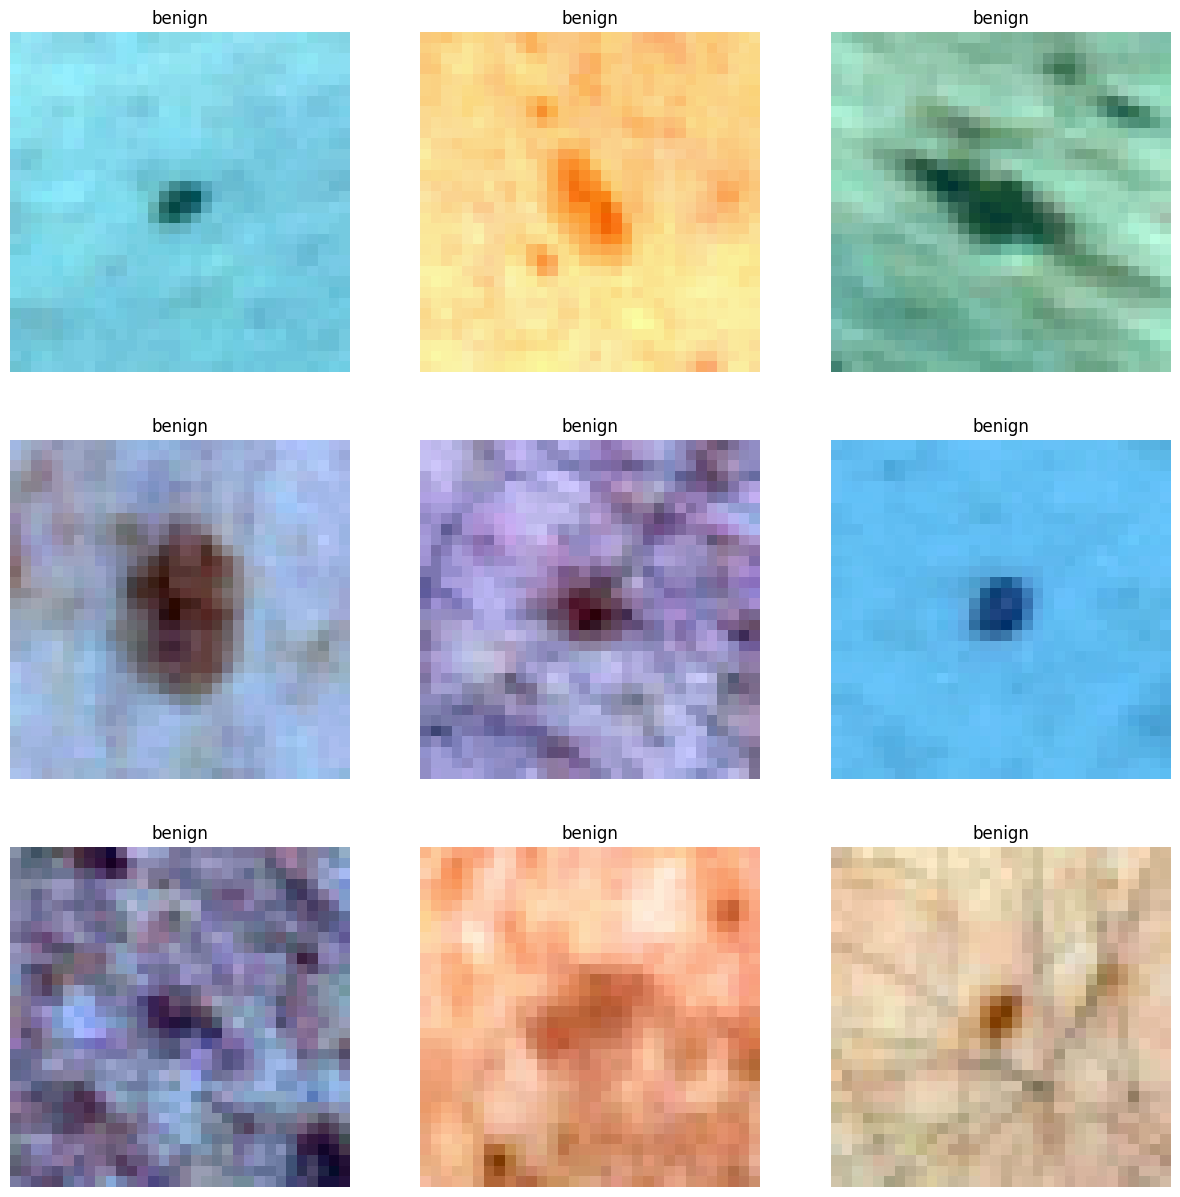

In [13]:
N_IMAGES = 10
j=int(len(train_image_ds)/2) - int(N_IMAGES/2)

images, labels = zip(*[(image, label) for image, label in
                          [train_image_ds[i+j] for i in range(N_IMAGES)]])

classes = train_image_ds.classes

plot_images(images, labels, classes)

**Model**

In [14]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64,3,2,1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,192,3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192,384,3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 *2 *2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim)
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [15]:
OUTPUT_DIM = 2

model = AlexNet(OUTPUT_DIM)

def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

**Number of Trainable Parameters Calculation**

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,239,490 trainable parameters


**Device configuration and Pipeline Setup**

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)


**Model Training and Validation and Hyperparameter Tuning**

In [18]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss =0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)



In [19]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins*60))
    return elapsed_mins, elapsed_secs

In [21]:
def get_predictions(model, iterator, device):

    model.eval()

    images =[]
    labels =[]
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
            #batch_size = x.shape[0]
        images = torch.cat(images, dim=0)
        labels = torch.cat(labels, dim=0)
        probs = torch.cat(probs, dim=0)

        return images, labels, probs

In [22]:
EPOCHS = 20

best_lr = None
best_valid_loss = float('inf')
best_model_state = None
results = []
lr_grid = [1e-1, 1e-2, 1e-3, 1e-4]

for lr in lr_grid:
    print(f"\nTuning learning rate: {lr}")

    model = AlexNet(OUTPUT_DIM).to (device)
    model.apply(initialize_parameters)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    valid_losses = []


    for epoch in trange(EPOCHS, desc="Epochs"):

        start_time = time.monotonic()

        train_loss, train_acc = train(model, train_image_iter, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(model, valid_image_iter, criterion, device)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_lr = lr
            best_model_state = model.state_dict()
            torch.save(model.state_dict(), 'best-model.pt')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

print(f"Best parameter: {best_lr}")


Tuning learning rate: 0.1


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 91857902500.672 | Train Acc: 57.97%
	 Val. Loss: 207318.369 |  Val. Acc: 25.00%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 56056.366 | Train Acc: 47.19%
	 Val. Loss: 4318.205 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 2638539.281 | Train Acc: 52.34%
	 Val. Loss: 19051.556 |  Val. Acc: 26.25%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 20776.042 | Train Acc: 51.25%
	 Val. Loss: 8808.277 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 34173.747 | Train Acc: 47.50%
	 Val. Loss: 19794.545 |  Val. Acc: 73.75%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 12308.051 | Train Acc: 51.72%
	 Val. Loss: 0.806 |  Val. Acc: 25.62%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 1356.847 | Train Acc: 51.25%
	 Val. Loss: 5.138 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 32.699 | Train Acc: 51.25%
	 Val. Loss: 17.352 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 3s
	Train Loss: 30.678 | Train Acc: 47.81%
	 Val. Loss: 29.531 |  Val. Acc: 25.62%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 3s
	Train Loss: 7807.943 | Train Acc: 53.59%
	 Val. Loss: 27.781 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 3s
	Train Loss: 59.475 | Train Acc: 51.09%
	 Val. Loss: 25.534 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 3s
	Train Loss: 51.731 | Train Acc: 50.78%
	 Val. Loss: 17.394 |  Val. Acc: 25.62%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 3s
	Train Loss: 41.098 | Train Acc: 55.31%
	 Val. Loss: 2.593 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 3s
	Train Loss: 36.234 | Train Acc: 50.62%
	 Val. Loss: 17.286 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 3s
	Train Loss: 24.628 | Train Acc: 56.25%
	 Val. Loss: 7.179 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 3s
	Train Loss: 24.255 | Train Acc: 51.56%
	 Val. Loss: 8.088 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 3s
	Train Loss: 19.746 | Train Acc: 53.75%
	 Val. Loss: 35.501 |  Val. Acc: 25.62%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 3s
	Train Loss: 19.978 | Train Acc: 55.00%
	 Val. Loss: 1.684 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 3s
	Train Loss: 13.420 | Train Acc: 52.97%
	 Val. Loss: 1.947 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 3s
	Train Loss: 11.466 | Train Acc: 50.78%
	 Val. Loss: 5.914 |  Val. Acc: 74.38%

Tuning learning rate: 0.01


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 42288.963 | Train Acc: 57.81%
	 Val. Loss: 0.959 |  Val. Acc: 73.75%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 1.612 | Train Acc: 57.81%
	 Val. Loss: 0.750 |  Val. Acc: 25.62%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 0.686 | Train Acc: 56.25%
	 Val. Loss: 0.631 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.691 | Train Acc: 57.50%
	 Val. Loss: 0.618 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 0.692 | Train Acc: 59.06%
	 Val. Loss: 0.614 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.680 | Train Acc: 59.38%
	 Val. Loss: 0.596 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 0.680 | Train Acc: 59.69%
	 Val. Loss: 0.638 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 0.676 | Train Acc: 59.22%
	 Val. Loss: 0.609 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 3s
	Train Loss: 0.681 | Train Acc: 58.91%
	 Val. Loss: 0.616 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 3s
	Train Loss: 0.683 | Train Acc: 57.97%
	 Val. Loss: 0.629 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 3s
	Train Loss: 0.682 | Train Acc: 58.75%
	 Val. Loss: 0.646 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 3s
	Train Loss: 0.682 | Train Acc: 58.59%
	 Val. Loss: 0.610 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 3s
	Train Loss: 0.680 | Train Acc: 59.22%
	 Val. Loss: 0.612 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 3s
	Train Loss: 0.678 | Train Acc: 59.38%
	 Val. Loss: 0.615 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 3s
	Train Loss: 0.680 | Train Acc: 58.91%
	 Val. Loss: 0.639 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 3s
	Train Loss: 0.685 | Train Acc: 58.75%
	 Val. Loss: 0.638 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 3s
	Train Loss: 0.681 | Train Acc: 58.75%
	 Val. Loss: 0.626 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 3s
	Train Loss: 0.677 | Train Acc: 59.22%
	 Val. Loss: 0.612 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 3s
	Train Loss: 0.678 | Train Acc: 59.38%
	 Val. Loss: 0.630 |  Val. Acc: 74.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 3s
	Train Loss: 0.677 | Train Acc: 59.22%
	 Val. Loss: 0.618 |  Val. Acc: 74.38%

Tuning learning rate: 0.001


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 18.684 | Train Acc: 50.16%
	 Val. Loss: 0.689 |  Val. Acc: 56.88%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.706 | Train Acc: 53.91%
	 Val. Loss: 0.672 |  Val. Acc: 76.25%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 0.666 | Train Acc: 61.41%
	 Val. Loss: 0.671 |  Val. Acc: 73.75%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.660 | Train Acc: 63.75%
	 Val. Loss: 0.626 |  Val. Acc: 75.00%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 0.671 | Train Acc: 62.97%
	 Val. Loss: 0.613 |  Val. Acc: 76.25%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.659 | Train Acc: 62.50%
	 Val. Loss: 0.616 |  Val. Acc: 75.62%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 0.628 | Train Acc: 66.56%
	 Val. Loss: 0.645 |  Val. Acc: 66.88%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 0.583 | Train Acc: 70.00%
	 Val. Loss: 0.592 |  Val. Acc: 76.88%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 3s
	Train Loss: 0.611 | Train Acc: 67.81%
	 Val. Loss: 0.515 |  Val. Acc: 75.62%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 3s
	Train Loss: 0.611 | Train Acc: 69.53%
	 Val. Loss: 0.595 |  Val. Acc: 76.25%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 3s
	Train Loss: 0.552 | Train Acc: 71.56%
	 Val. Loss: 0.630 |  Val. Acc: 65.00%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 3s
	Train Loss: 0.554 | Train Acc: 73.75%
	 Val. Loss: 0.502 |  Val. Acc: 76.25%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 3s
	Train Loss: 0.541 | Train Acc: 73.28%
	 Val. Loss: 0.547 |  Val. Acc: 72.50%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 3s
	Train Loss: 0.555 | Train Acc: 74.06%
	 Val. Loss: 0.556 |  Val. Acc: 69.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 3s
	Train Loss: 0.544 | Train Acc: 72.19%
	 Val. Loss: 0.459 |  Val. Acc: 82.50%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 3s
	Train Loss: 0.514 | Train Acc: 76.72%
	 Val. Loss: 0.549 |  Val. Acc: 68.75%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 3s
	Train Loss: 0.521 | Train Acc: 75.00%
	 Val. Loss: 0.462 |  Val. Acc: 83.75%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 3s
	Train Loss: 0.473 | Train Acc: 77.97%
	 Val. Loss: 0.416 |  Val. Acc: 81.88%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 3s
	Train Loss: 0.518 | Train Acc: 75.31%
	 Val. Loss: 0.438 |  Val. Acc: 79.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 3s
	Train Loss: 0.480 | Train Acc: 77.66%
	 Val. Loss: 0.410 |  Val. Acc: 81.88%

Tuning learning rate: 0.0001


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 5.059 | Train Acc: 51.72%
	 Val. Loss: 1.005 |  Val. Acc: 41.88%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 1.852 | Train Acc: 55.78%
	 Val. Loss: 2.038 |  Val. Acc: 25.62%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 1.396 | Train Acc: 58.13%
	 Val. Loss: 0.977 |  Val. Acc: 36.88%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.944 | Train Acc: 59.22%
	 Val. Loss: 1.040 |  Val. Acc: 31.87%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 0.914 | Train Acc: 58.59%
	 Val. Loss: 0.547 |  Val. Acc: 72.50%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.854 | Train Acc: 60.94%
	 Val. Loss: 0.683 |  Val. Acc: 64.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 0.705 | Train Acc: 67.19%
	 Val. Loss: 0.618 |  Val. Acc: 66.88%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 0.772 | Train Acc: 62.66%
	 Val. Loss: 0.746 |  Val. Acc: 59.38%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 3s
	Train Loss: 0.768 | Train Acc: 63.91%
	 Val. Loss: 0.673 |  Val. Acc: 67.50%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 3s
	Train Loss: 0.714 | Train Acc: 64.69%
	 Val. Loss: 0.630 |  Val. Acc: 70.62%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 3s
	Train Loss: 0.626 | Train Acc: 68.59%
	 Val. Loss: 0.682 |  Val. Acc: 66.25%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 3s
	Train Loss: 0.705 | Train Acc: 66.25%
	 Val. Loss: 0.801 |  Val. Acc: 53.75%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 3s
	Train Loss: 0.799 | Train Acc: 61.72%
	 Val. Loss: 0.498 |  Val. Acc: 80.00%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 3s
	Train Loss: 0.644 | Train Acc: 67.03%
	 Val. Loss: 0.601 |  Val. Acc: 71.88%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 3s
	Train Loss: 0.590 | Train Acc: 71.56%
	 Val. Loss: 0.555 |  Val. Acc: 75.62%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 3s
	Train Loss: 0.609 | Train Acc: 72.03%
	 Val. Loss: 0.492 |  Val. Acc: 78.75%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 3s
	Train Loss: 0.595 | Train Acc: 71.09%
	 Val. Loss: 0.683 |  Val. Acc: 65.62%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 3s
	Train Loss: 0.621 | Train Acc: 70.16%
	 Val. Loss: 0.729 |  Val. Acc: 60.62%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 3s
	Train Loss: 0.628 | Train Acc: 69.84%
	 Val. Loss: 0.507 |  Val. Acc: 78.12%


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 3s
	Train Loss: 0.600 | Train Acc: 71.25%
	 Val. Loss: 0.549 |  Val. Acc: 75.00%
Best parameter: 0.001


**Training/Validation Loss Plot**

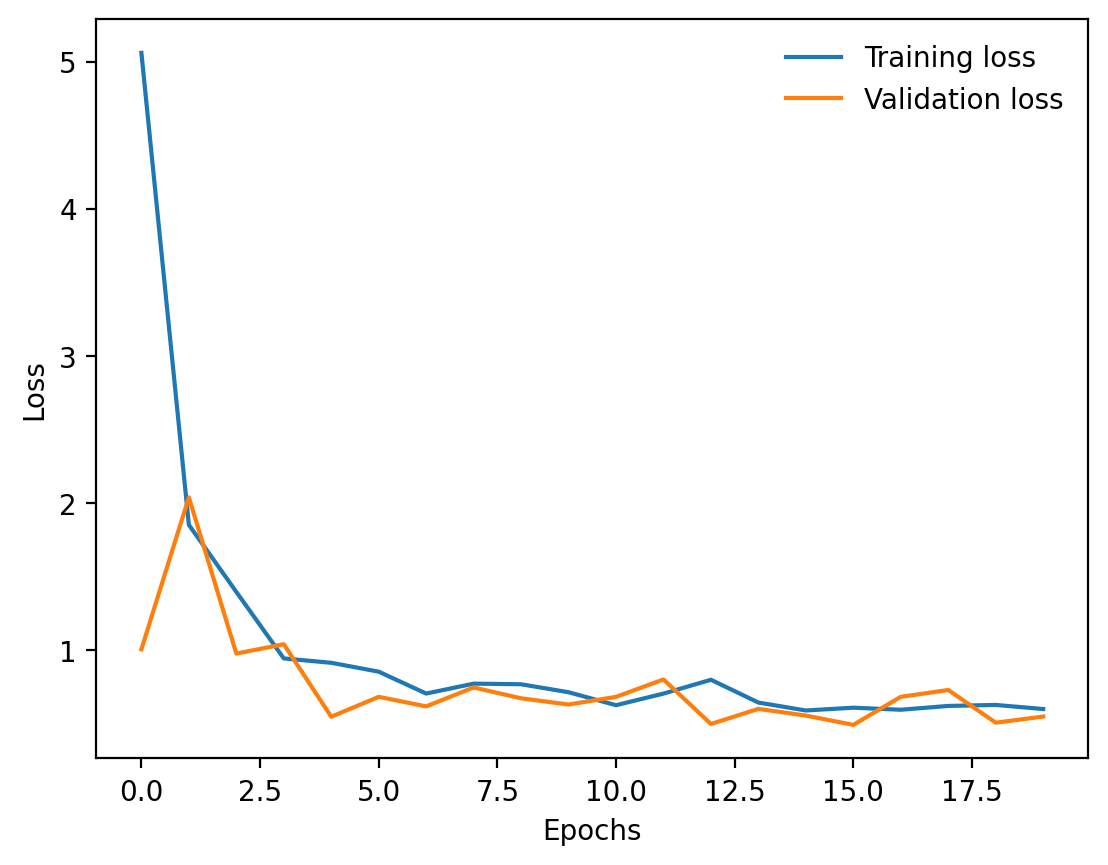

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

**Model Testing**

In [24]:
model.load_state_dict(torch.load('best-model.pt'))

<All keys matched successfully>

In [25]:
images, labels, probs = get_predictions(model, test_image_iter, device)

In [26]:
test = pd.read_csv('/content/drive/My Drive/Kwok_Bo_22454220_Code/test_image_isic_id_target.csv')
y_test = np.array(test.drop(['isic_id'], axis=1))

In [27]:
def calculate_accuracy_from_predictions(preds, labels):
    correct = (preds == labels).sum()
    return correct / len(labels)

pred_class = np.argmax(probs, axis=1)
true_class = y_test

test_accuracy = calculate_accuracy_from_predictions(pred_class, true_class.flatten())
print(f"Accuracy for Test Set: {test_accuracy:.3f}")

Accuracy for Test Set: 0.562


**ROC & ROC Curve**

Test Set ROC-AUC Score: 0.581


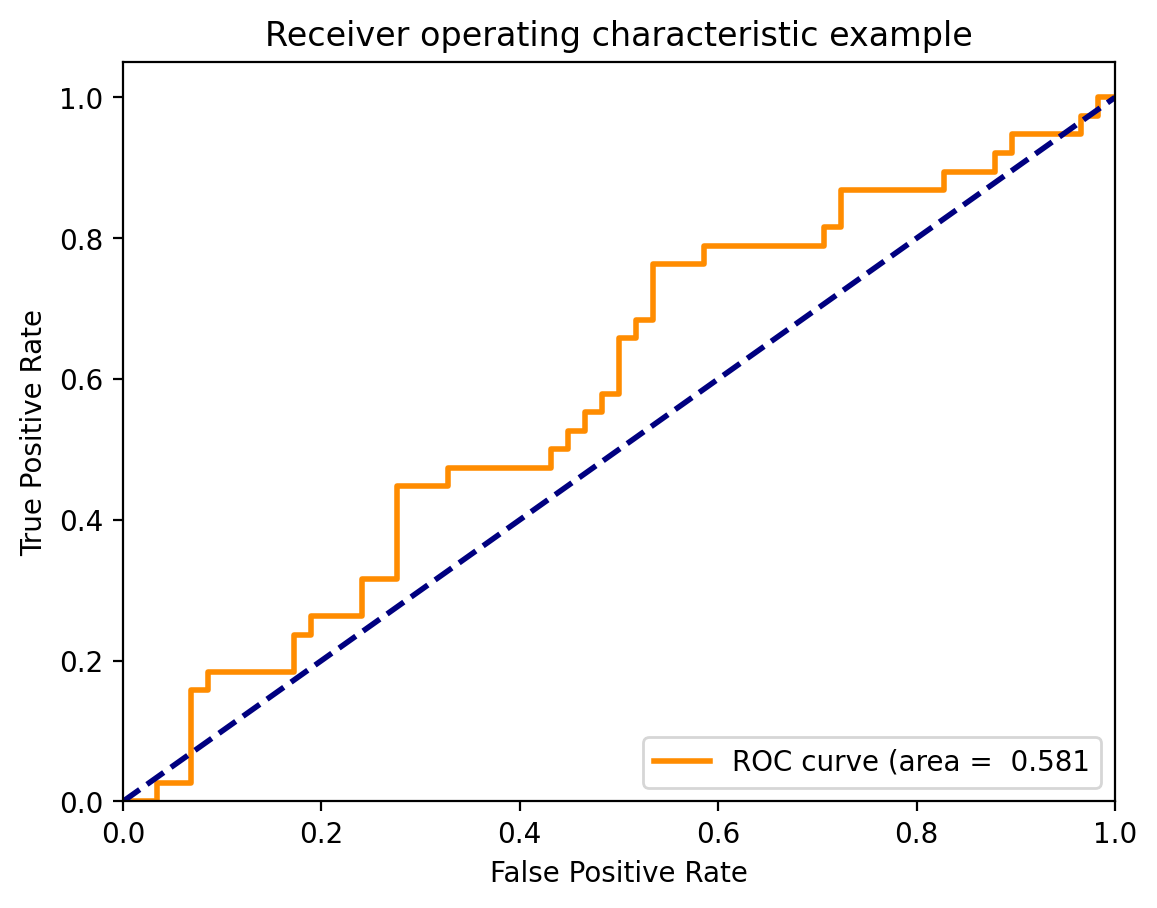

In [28]:
fpr, tpr, _ = roc_curve(y_test, probs[:, 1])
roc_auc =auc(fpr, tpr)
print(f"Test Set ROC-AUC Score: {roc_auc:.3f}")

plt.figure()
lw=2
plt.plot(fpr,tpr,color='darkorange', lw = lw, label =f'ROC curve (area =  {roc_auc:.3f}')
plt.plot([0, 1],[0,1], color='navy', lw = lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

**Unnormalized and Normalized Confusion Matrix**

[[36 22]
 [20 18]]
Unnormalized Confusion Matrix for Test Set
[0 1]


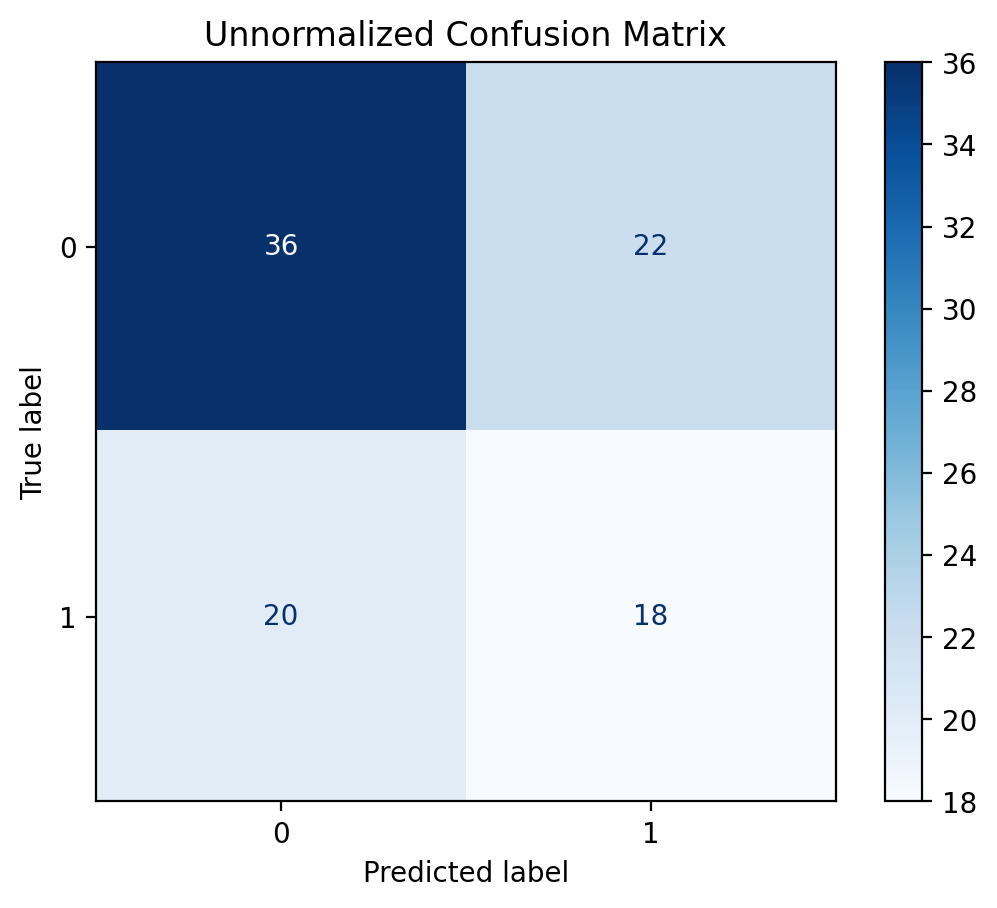

[58 38]
[[58. 58.]
 [38. 38.]]
Normalized Confusion Matrix for Test Set
[[0.62 0.38]
 [0.53 0.47]]


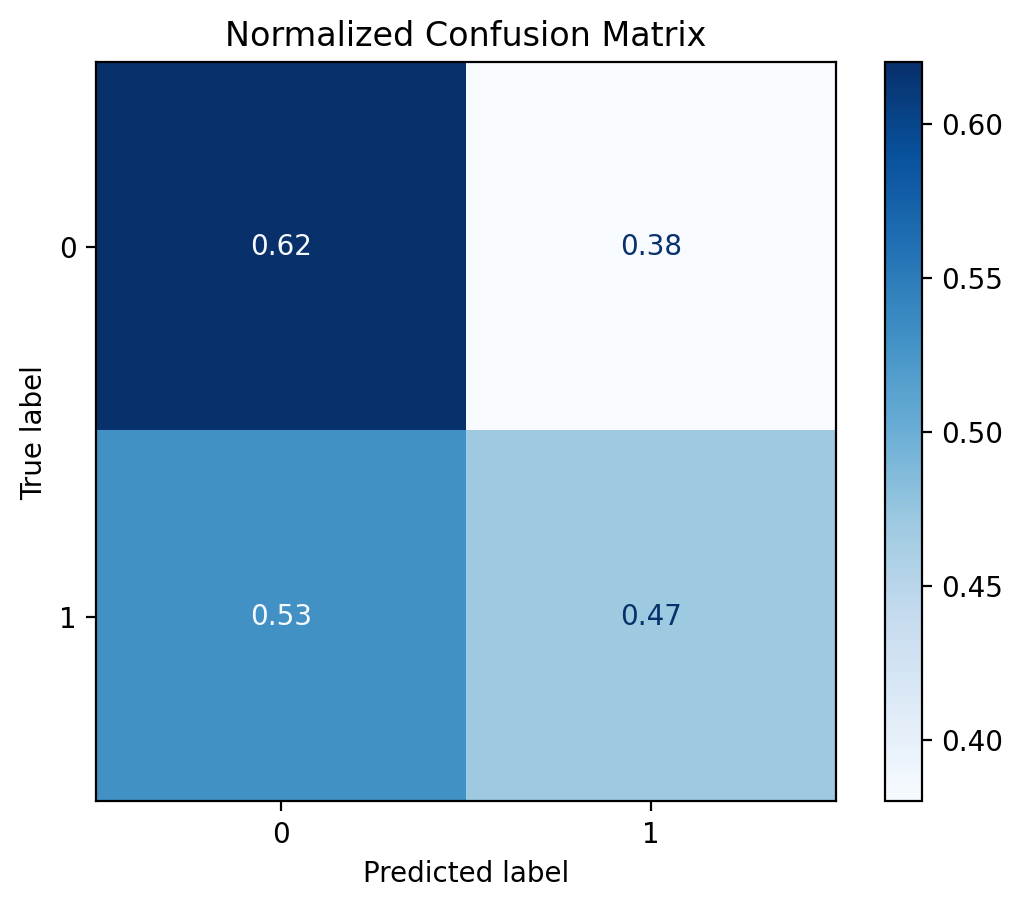

In [29]:
cm = confusion_matrix(true_class, pred_class)
class_names = unique_labels(true_class, pred_class)
print(cm)
print("Unnormalized Confusion Matrix for Test Set")
print(class_names)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Unnormalized Confusion Matrix")
plt.show()

C = cm
divisor = np.zeros((2,2))
divisor[0][:] = cm.sum(axis=1)[0]
divisor[1][:] = cm.sum(axis=1)[1]
cm_normalised = np.divide(cm, divisor)
print(np.transpose((C.sum(axis=1))))
print(divisor)

cm_normalised = np.round(cm_normalised, 2)
print("Normalized Confusion Matrix for Test Set")
print(cm_normalised)
disp = ConfusionMatrixDisplay(cm_normalised, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format="")
plt.title("Normalized Confusion Matrix")
plt.show()


**Precision, Recall, F1-score**

In [30]:
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP

precision_per_class = TP / (TP + FP)
recall_per_class = TP / (TP + FN)
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)

precision = np.mean(precision_per_class)
recall = np.mean(recall_per_class)
f1 = np.mean(f1_per_class)

print(f"Precision : {precision:.3f}")
print(f"Recall : {recall:.3f}")
print(f"F1-score : {f1:.3f}")

Precision : 0.546
Recall : 0.547
F1-score : 0.547
